<a href="https://colab.research.google.com/github/suinkangme/COMP432-GroupI/blob/main/task1_training_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import seaborn as sns

In [2]:
# ADD SHORTCUT FROM COMP432 FOLDER TO YOUR COLAB NOTEBOOK FOLDER THEN ON THE LEFT HAND SIZE IN COLAB, UNDER "FILE", LOOK FOR THE PATH.
# RUN THIS PART TO LOAD NPZ FILES

from google.colab import drive
drive.mount('/content/drive')

# Load the training data
train_data = np.load('/content/drive/MyDrive/Colab Notebooks/COMP432/Preprocessed Data/Dataset 1/train_data.npz')
X_train = train_data['images']
y_train = train_data['labels']

# Load the testing data
test_data = np.load('/content/drive/MyDrive/Colab Notebooks/COMP432/Preprocessed Data/Dataset 1/test_data.npz')
X_test = test_data['images']
y_test = test_data['labels']


Mounted at /content/drive


In [ ]:
# Load the training and testing data
# X_train = np.load('/content/train_images.npy')
# y_train = np.load('/content/train_labels.npy')
# X_test = np.load('/content/test_images.npy')
# y_test = np.load('/content/test_labels.npy')

In [3]:
# Convert the data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

classes = ['MUS', 'NORM', 'STR']

In [4]:
# DataLoader for training and test data
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define ResNet-18 model with pre-trained weights
model = resnet18(weights = None)
num_classes = len(classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

In [5]:
# Set loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [16]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []

# Training the model
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        batch_size = images.shape[0]
        h = images.shape[1]
        w = images.shape[2]
        channels = images.shape[3]
        images = torch.reshape(images, (batch_size, channels, h, w))
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate and store training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Print training loss and accuracy for each epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')


Epoch 1/20, Train Loss: 0.1311, Train Accuracy: 94.85%
Epoch 2/20, Train Loss: 0.1170, Train Accuracy: 95.65%
Epoch 3/20, Train Loss: 0.1073, Train Accuracy: 95.79%
Epoch 4/20, Train Loss: 0.1213, Train Accuracy: 95.54%
Epoch 5/20, Train Loss: 0.1479, Train Accuracy: 94.46%
Epoch 6/20, Train Loss: 0.0879, Train Accuracy: 96.73%
Epoch 7/20, Train Loss: 0.0985, Train Accuracy: 96.77%
Epoch 8/20, Train Loss: 0.0783, Train Accuracy: 97.27%
Epoch 9/20, Train Loss: 0.0704, Train Accuracy: 97.56%
Epoch 10/20, Train Loss: 0.0887, Train Accuracy: 96.54%
Epoch 11/20, Train Loss: 0.0863, Train Accuracy: 96.96%
Epoch 12/20, Train Loss: 0.0598, Train Accuracy: 97.90%
Epoch 13/20, Train Loss: 0.0680, Train Accuracy: 97.65%
Epoch 14/20, Train Loss: 0.0403, Train Accuracy: 98.62%
Epoch 15/20, Train Loss: 0.0634, Train Accuracy: 97.48%


KeyboardInterrupt: ignored

In [13]:
# ONLY RUN THIS IF YOU ARE TRAINING FOR THE FIRS TIME. IF YOU ALREADY HAVE A MODEL,
# DO NOT RUN THIS PART AGAIN.

# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir('/content/drive/MyDrive/comp432/')

# torch.save(model.state_dict(), '/content/drive/MyDrive/comp432/resnet18_model.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: ignored

### Note (During the training the model)

### Try 1
-> train accuracy 64.02% at Epoch 10/10.

number of epoch = 10,

batch size = 64,

optimizer = SGD(with regularization - weight_decay),


### Try 2 - change the optimizer to adam & remove regularization(weight decay) and dropout layer
-> train accuracy 77.92% at Epoch 10/10.

optimizer = adam(without regularization),


### Try 3 - train with more epoch
->  train accuracy 88.98% at Epoch 20/20.

number of epoch = 20




# **Testing**
*Notice : To run the tesing code below, you are required to this:
1. Run all the code above EXCEPT those cells where the model is trained and saved. This is to load the testing data.
2. Go download the saved model in our shared folder.
3. Upload the pth file. Do not make any directory.


In [8]:
state_dict = torch.load ('/content/drive/MyDrive/Colab Notebooks/COMP432/Project/Project Implementation/resnet18_model.pth', map_location = torch.device('cpu'))
#in case you are curious what the weights look like ...
#print(state_dict)

In [9]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
from sklearn.metrics import classification_report
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
running_loss = 0
total = 0
correct = 0
y_pred = []
y_test = []
with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    batch_size= images.shape[0]
    h= images.shape[1]
    w= images.shape[2]
    channels= images.shape[3]
    images= torch.reshape(images,(batch_size,channels,h,w))
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    y_pred.append(predicted)
    y_test.append(labels)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

y_pred_torch = torch.stack(y_pred[0:-1], dim=1)
y_test_torch = torch.stack(y_test[0:-1], dim=1)

y_pred_torch = y_pred_torch.cpu().detach().numpy()
y_test_torch = y_test_torch.cpu().detach().numpy()
target_names = ['MUS', 'NORM', 'STR']
y_pred_torch = np.reshape(y_pred_torch,(-1, 1))
y_test_torch = np.reshape(y_test_torch, (-1, 1))
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)
print(classification_report(y_test_torch, y_pred_torch, target_names = target_names))
test_loss = running_loss / len(train_loader)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

              precision    recall  f1-score   support

         MUS       0.87      0.87      0.87       388
        NORM       0.90      0.96      0.93       378
         STR       0.86      0.80      0.83       386

    accuracy                           0.88      1152
   macro avg       0.88      0.88      0.88      1152
weighted avg       0.88      0.88      0.88      1152

Test Loss: 0.0837, Test Accuracy: 87.75%


In [ ]:
#feature extraction
extracted_features = []
with torch.no_grad():
  for batch in train_loader:
    images, _ = batch
    images = images.to(device)
    batch_size= images.shape[0]
    h= images.shape[1]
    w= images.shape[2]
    channels= images.shape[3]
    images= torch.reshape(images,(batch_size,channels,h,w))
    features = model(images)
    features = features.view(features.size(0), -1)
    extracted_features.append(features.cpu().numpy())

# Concatenate all features to get the full feature set
extracted_features = np.concatenate(extracted_features, axis=0)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state = 0)
tsne_result = tsne.fit_transform(extracted_features)

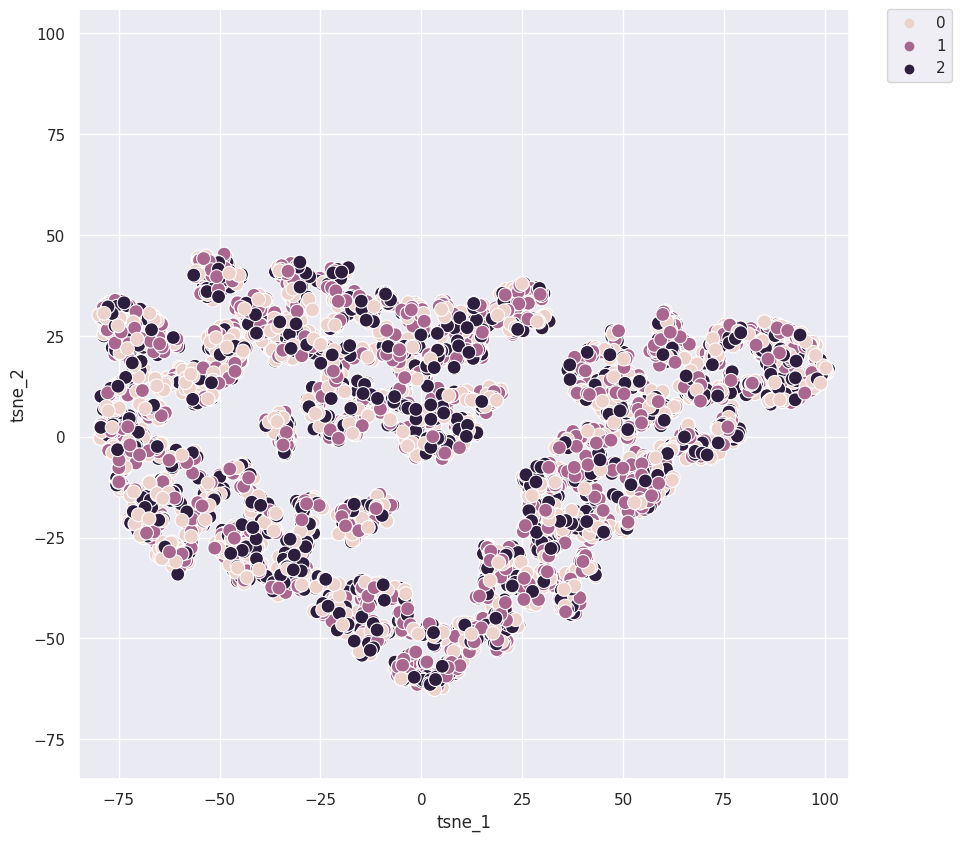

In [ ]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y_train})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=100)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

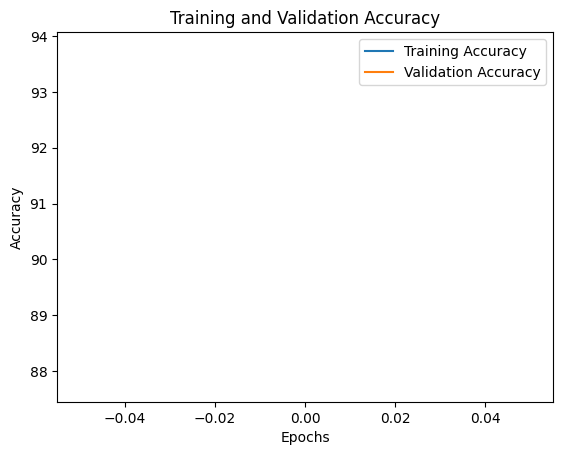

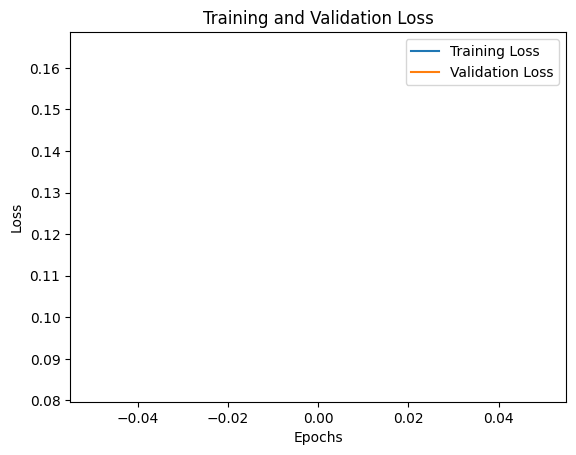

In [15]:
# import matplotlib.pyplot as plt

# # Function for plotting
# def plot_metrics(train_metric, val_metric, metric_name):
#     plt.plot(train_metric, label=f'Training {metric_name}')
#     plt.plot(val_metric, label=f'Validation {metric_name}')
#     plt.title(f'Training and Validation {metric_name}')
#     plt.xlabel('Epochs')
#     plt.ylabel(metric_name)
#     plt.legend()
#     plt.show()

# # Plotting the accuracy
# plot_metrics(train_accuracy, test_accuracy, 'Accuracy')

# # Plotting the loss
# plot_metrics(train_loss, test_loss, 'Loss')